<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXnrruP7guibF61c4gOESBR2VhhqYmEjKin0yY9lrhCak3hIbXI0QDSlObO74xcBkjMw&usqp=CAU"/></center>

# 🔍 Build a nest - OFFLINE 

<small>
This notebook allows you to build a child grid/a nest from a parent grid (created with <strong>`make_grid.ipynb`</strong>) with offline or AGRIF methods
<br>💡 It is linked to the croco-ocean/croco_pytools' <a href= "https://gitlab.inria.fr/croco-ocean/croco_pytools/-/issues/4">ISSUE #4</a> located on the <strong>croco-ocean INRIA's gitlab</strong>
<br>➡️ Notebook created by <a href="mailto:thibault.delahaye@ird.fr">Thibault Delahaye</a> and based on the existing codes of pycrocotool
<br>🌳 Developped on **notebook-grid-tools**'s branch, whose source is the main branch
</small>

## 📖-Code-presentation

### Method

<div class="alert alert-block alert-info">

To represent fine-scale phenomena, CROCO offers the ability to create zooms with increased resolution. Two options exist 🛠️:

<div style="border: 2px dotted black; padding: 10px; margin: 10px;">
    
##### Offline Zoom 🗺️ ➡️ 🔍

- **Description**: Creation of a grid with the desired resolution, where the boundaries are within a grid of a larger CROCO domain, already modeled.
- **Conditions**: The high-resolution grid takes as initial and boundary conditions those from the larger CROCO simulation. The simulations are independent and no feedback from the high-resolution grid to the coarser grid is possible. The simulations run separately.
- **Advantages**:
  - Independence
  - No constraints on the chosen resolution
- **Disadvantages**:
  - No feedback to the larger domain
  - Zoom boundary forcing depends on the frequency of the parent grid’s history, which may filter out some waves present in the parent grid.
</div>
##### AGRIF Zoom 🔄

- **Description**: AGRIF is a library that allows running CROCO with several embedded domains together. (see documentation in CROCO documentation)
- **Conditions**: Parent and child(s) domains are run simultaneously, coupling the domains at the barotropic time step.
- **Advantages**:
  - Two-way feedback to the parent domain is possible and can significantly improve results of the larger domain
  - Coupling at the highest possible frequency
  - Consistency of numerics
  - Any number of nesting levels is allowed
- **Disadvantages**:
  - Requires simultaneous execution of the parent and child(s) grids
  - Nesting ratio should be 3 or 5
  - Currently, AGRIF zooms in CROCO must have the same vertical resolution as the parent.

</div>

### 💾 Datasets

Further Information: [CROCO OCEAN WEBSITE](http://www.croco-ocean.org)
  
*This file is part of CROCOTOOLS* 🐊

**Create a CROCO grid file** 🌐   
In the current state the script can handle:  

<table style="width: 100%; text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">DATA</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">SOURCE</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">FILE EXTENSION</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>⛰️ topo/bathy</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">etopo (5,2,1),<br>srtm30, gebco</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🏖️ coastline</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">GSHHS</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>shapefile</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>🐊 parent CROCO grid</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">croco_grd built with make_grid.ipynb</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
  </tbody>
</table>

### ⚙️ Requirements
➡️ Installing `ipympl` for interactive Plots :

*To use **interactive plotting** features with the `%matplotlib widget` [magic command](#Magic-cells) in Jupyter Notebook or JupyterLab, you need to install the `ipympl` package. This package enables Matplotlib to render interactive plots using Jupyter widgets.*

 **Run the following command** in a code cell or in your notebook to install `ipympl`:
   ```python
   pip install ipympl
   ```

---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  CODE BODY
</div>

---

### Magic cells

[Magic cell](https://ipython.readthedocs.io/en/stable/interactive/magics.html) ⚡🐚 dedicated to the activation of backend environments

In [1]:
#Allows widget interactivity with user
%matplotlib widget    
%load_ext autoreload
%autoreload 2

### Dependencies

In [2]:
import numpy as np
import os,sys
os.environ['ETS_TOOLKIT'] = 'wx'
sys.path.append("./Modules/")
sys.path.append("./Readers/")
sys.path.append("./Modules/graphicUI_tools/")
from main_window import *
import tools_make_grid
#----------------------------------------------#
from tools_make_grid import inputs,inputs_smth,EasyGrid,GetMask,GetTopo, topo_prt
from croco_class import CROCO
from main_window import Outputs
#----------------------------------------------#
from Modules.map_tools.map_tools import plot_grid, plot_outline, plot_topo
from scipy.spatial import distance
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact_manual
#----------------------------------------------#
from matplotlib.widgets import RectangleSelector
from ipywidgets import FloatText, VBox
from IPython.display import display, clear_output

## 🗺️ Parent grid path and infos

### Parent grid path:

In [3]:
parent_grid_file= "../../CROCO_FILES/croco_grd.nc"

### Collecting parent's grid inputs/outputs parameters

#### Collecting parent's grid inputs

In [4]:
import json
import pandas as pd
import os

output_folder = os.path.dirname(parent_grid_file)
json_filename = 'user_inputs.json'

json_file_path= os.path.join(output_folder, json_filename)

# Lire le fichier JSON
with open(json_file_path, 'r') as json_file:
    user_inputs_parent = json.load(json_file)
    
# Convertir les sous-dictionnaires en DataFrames séparés
df_inputs = pd.DataFrame([user_inputs_parent['inputs']])
df_inputs_smth = pd.DataFrame([user_inputs_parent['inputs_smth']])

**PARENT GRID INPUTS**

In [5]:
df_inputs

,tra_lon,tra_lat,size_x,size_y,rot,nx,ny
0,15,-32,1556,1334,0,39,40


**PARENT GRID SMOOTHING PARAMETERS**

In [6]:
df_inputs_smth

,depthmin,depthmax,smthr,rfact,smooth
0,50,6000,2,0.2,lsmooth


In [29]:
#### Collecting parent's grid outputs

In [7]:
prt= topo_prt(parent_grid_file)

## 🐣 Build the nest

### Create a new child grid

#### ✏️🔧 User's changes

##### Center's position (degrees) 📍

In [8]:
tra_lon =  15 # Longitude of the grid center 
tra_lat = -32 # Latitude of the grid center

##### Grid extent (km) and resolution

In [9]:
# Grid size [km]
size_x = 150
size_y = 130

# Grid number of points 
nx = 10 #39
ny = 11 #40

In [10]:
# Calculate Resolution
delta_x = size_x / nx
delta_y = size_y / ny

# Display results
print(f"Resolution in X direction: {delta_x:.2f} km")
print(f"Resolution in Y direction: {delta_y:.2f} km")

Resolution in X direction: 15.00 km
Resolution in Y direction: 11.82 km


##### Grid rotation (degrees)

In [11]:
rot = 0

#### Smoothing settings

See [online documentation](https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.grid.html) for more details 📚

In [12]:
hmin        = 50    # Minimum depth [m]
hmax        = 6000  # Maximum depth [m]
interp_rad  = 2     # Interpolation radius in number of points (usually between 2 and 8)
rfact       = 0.2   # Maximum r-fact to reach (the lower it is, the smoother it will be)    
smooth_meth = 'lsmooth' # Smoothing method ('smooth', 'lsmooth', 'lsmooth_legacy', 'lsmooth2', 'lsmooth1', 'cond_rx0_topo') 

##### Paths

###### Inputs

Topo/bathy file ⛰️ :

In [13]:
topofile = '../../DATASETS_CROCOTOOLS/Topo/etopo2.nc'

Coastline file (for the mask) 🏖️ :

In [14]:
shp_file = '../../DATASETS_CROCOTOOLS/gshhs/GSHHS_shp/i/GSHHS_i_L1.shp'

###### Output(s)

Output grid file 🔲:

In [15]:
output_file="../../CROCO_FILES/croco_chd_grd.nc"

##### Mask

Single Connect (Masks water not connected to the main water body) 🎭:

In [16]:
sgl_connect=[False,20,20] # True or False, point indices inside the main water body

##### Open boundary conditions

<div style="border: 2px solid yellow; padding: 10px; background-color: #fff3e0;">
    <strong>🚨 CHECKBOX SELECTION:</strong> SIMPLY RUN THE NEXT CELL TO SELECT OBCs
</div>

###### Run widget

In [21]:
# Define variables to store the settings
settings = {
    'NORTH': True,
    'SOUTH': True,
    'WEST': True,
    'EAST': True,
    'MERGING_AREA': 5  # Set default value to 5
}

# Function to handle saving values
def save_values(b):
    # Update settings with current values
    settings['NORTH'] = north_checkbox.value
    settings['SOUTH'] = south_checkbox.value
    settings['WEST'] = west_checkbox.value
    settings['EAST'] = east_checkbox.value
    settings['MERGING_AREA'] = merging_area_text.value
    
    # Display confirmation message
    with output:
        clear_output()
        print("Settings have been saved.")
        print(settings)  # Display current settings for verification

# Create checkboxes for each border
north_checkbox = widgets.Checkbox(value=settings['NORTH'], description='North Border ⬆️')
south_checkbox = widgets.Checkbox(value=settings['SOUTH'], description='South Border ⬇️')
west_checkbox = widgets.Checkbox(value=settings['WEST'], description='West Border ⬅️')
east_checkbox = widgets.Checkbox(value=settings['EAST'], description='East Border ➡️')

# Create a field for the "Merging Area" parameter as an integer with default value 5
merging_area_text = widgets.IntText(
    value=settings['MERGING_AREA'], 
    layout=widgets.Layout(width='100px')  # Adjust width of the input field
)
merging_area_label = widgets.Label(
    value='Merging Area:', 
    layout=widgets.Layout(width='150px', display='flex', justify_content='flex-end')  # Adjust label width and alignment
)

# Create an HBox for the label and input field
merging_area_box = widgets.HBox(children=[
    merging_area_label, 
    merging_area_text
])

# Create a button to save the settings
save_button = widgets.Button(description="Save Settings")
save_button.on_click(save_values)

# Create a box around the widgets with custom styling
border_box = widgets.VBox(children=[
    north_checkbox, 
    south_checkbox, 
    west_checkbox, 
    east_checkbox,
    merging_area_box,
    save_button
])

# Apply CSS styles to the box
border_box.layout.border = '2px solid #007bff'
border_box.layout.padding = '10px'
border_box.layout.border_radius = '5px'
border_box.layout.margin = '10px'
border_box.layout.width = '400px'  # Increase width to ensure full visibility

# Adjust width of individual widgets
north_checkbox.layout.width = '100%'
south_checkbox.layout.width = '100%'
west_checkbox.layout.width = '100%'
east_checkbox.layout.width = '100%'
merging_area_text.layout.width = '100px'  # Set a specific width for the input field

# Create an output area for displaying messages
output = widgets.Output()

###### Select parameters for OBC's

In [22]:
# Display the box and output area
display(border_box, output)

Output()

#### ⚙️🌐 Building the grid

##### Creating classes for inputs/outputs

In [17]:
inputs=inputs(tra_lon,tra_lat,size_x,size_y,nx,ny,rot)
inputs_smth=inputs_smth(hmin,hmax,interp_rad,rfact,smooth_meth)
outputs=Outputs()

##### Create lon/lat grid 

In [18]:
EasyGrid.easygrid(None,inputs,outputs)

##### Building the mask and smoothing topo

<div class="alert alert-block alert-warning"> 
Tip: if the ouput is too long 🖱️ right click on the cell annd "Enable scrolling for outputs"
</div>

In [19]:
#GetTopo.topo(None,outputs,topofile,shp_file,smooth=inputs_smth,sgl_connect=sgl_connect)
GetTopo.topo(None,outputs, topofile, shp_file, smooth= inputs_smth, sgl_connect=sgl_connect, prt_grd=prt)

Reading topography file: ../../DATASETS_CROCOTOOLS/Topo/etopo2.nc
Single region dataset imin/imax= 5808 5891
Bounding indices of the relevant part to be extracted from the entire dataset:
 imin,imax = 5808 5891 out of 10800 jmin,jmax = 1710 1770 out of 5400
Interpolating topography to CROCO grid
Finished interpolating

 Geographical extents of the dataset:
ratio between prt and chld grid is approx: 2
    Longitude min/max =   13.600000   16.366667
    Latitude  min/max =  -33.000000  -31.000000

 Geographical extents of requested ROMS grid:
    Longitude min/max =   13.636036   16.363964
    Latitude  min/max =  -32.956451  -31.037594

 Bounding indices for the portion of dataset covering the entire model grid:
 iwest,ieast =    2    83 out of    84 jsouth,jnorth =    2    59 out of    61

 Averaging window width = 2.00000 in grid spaces.

...

 Wall Clock time spent to compute hraw    0.00 sec running   1 threads.
Matching Parent and Child mask close to boundary
 enter smooth_thread r

704059    11   10 ry_max = 0.1393016
   29     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   30     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   31     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   32     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   33     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   34     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   35     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   36     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   37     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   38     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   39     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   40     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   41     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   42     9    9 rx_max = 0.0704059    11   10 ry_max = 0.1393016
   43     9    9 rx_max = 0.0704059    

#### 🪨🧩 Connecting parent/child topo's

<div style="border: 2px solid yellow; padding: 10px; background-color: #fff3e0;">
    <strong>🚨 CHECKBOX SELECTION:</strong> SIMPLY RUN THE NEXT CELL TO SELECT OBCs
</div>

In [20]:
# Define variables to store the settings
settings = {
    'NORTH': True,
    'SOUTH': True,
    'WEST': True,
    'EAST': True,
    'MERGING_AREA': 5  # Set default value to 5
}

# Function to handle saving values
def save_values(b):
    # Update settings with current values
    settings['NORTH'] = north_checkbox.value
    settings['SOUTH'] = south_checkbox.value
    settings['WEST'] = west_checkbox.value
    settings['EAST'] = east_checkbox.value
    settings['MERGING_AREA'] = merging_area_text.value
    
    # Display confirmation message
    with output:
        clear_output()
        print("Settings have been saved.")
        print(settings)  # Display current settings for verification

# Create checkboxes for each border
north_checkbox = widgets.Checkbox(value=settings['NORTH'], description='North Border')
south_checkbox = widgets.Checkbox(value=settings['SOUTH'], description='South Border')
west_checkbox = widgets.Checkbox(value=settings['WEST'], description='West Border')
east_checkbox = widgets.Checkbox(value=settings['EAST'], description='East Border')

# Create a field for the "Merging Area" parameter as an integer with default value 5
merging_area_text = widgets.IntText(
    value=settings['MERGING_AREA'], 
    layout=widgets.Layout(width='100px')  # Adjust width of the input field
)
merging_area_label = widgets.Label(
    value='Merging Area:', 
    layout=widgets.Layout(width='150px', display='flex', justify_content='flex-end')  # Adjust label width and alignment
)

# Create an HBox for the label and input field
merging_area_box = widgets.HBox(children=[
    merging_area_label, 
    merging_area_text
])

# Create a button to save the settings
save_button = widgets.Button(description="Save Settings")
save_button.on_click(save_values)

# Create a box around the widgets with custom styling
border_box = widgets.VBox(children=[
    north_checkbox, 
    south_checkbox, 
    west_checkbox, 
    east_checkbox,
    merging_area_box,
    save_button
])

# Apply CSS styles to the box
border_box.layout.border = '2px solid #007bff'
border_box.layout.padding = '10px'
border_box.layout.border_radius = '5px'
border_box.layout.margin = '10px'
border_box.layout.width = '400px'  # Increase width to ensure full visibility

# Adjust width of individual widgets
north_checkbox.layout.width = '100%'
south_checkbox.layout.width = '100%'
west_checkbox.layout.width = '100%'
east_checkbox.layout.width = '100%'
merging_area_text.layout.width = '100px'  # Set a specific width for the input field

# Create an output area for displaying messages
output = widgets.Output()

# Display the box and output area
display(border_box, output)

Output()

##### Run the topo matching function

<div class="alert alert-block alert-info">
<strong>Topo parent-child smoothing:</strong> Currently the code used to match parent/child grids'topo is the fortran one, a python version is under construction
</div>

In [21]:
import copy
outputs_original= copy.deepcopy(outputs)

In [24]:
directions = []
if settings['WEST']:
    directions.append('West')
if settings['EAST']:
    directions.append('East')
if settings['SOUTH']:
    directions.append('South')
if settings['NORTH']:
    directions.append('North')
settings['dirs'] = directions

GetTopo.match_topo(None,prt,outputs,[settings['dirs'],settings['MERGING_AREA']])

#topo= toolsf.r2r_match_topo(settings['WEST'],settings['EAST'],settings['SOUTH'],settings['NORTH'],nx ,ny , iip, jjp, settings['MERGING_AREA'],outputs.lon_rho.T,outputs.lat_rho.T,outputs.h.T,mask_tmp.T,\
                                  #prt.lon_rho.T,prt.lat_rho.T,prt.h.T)

 allocated           0 MB total
 allocated           0 MB total
 Parent grid xmin,xmax =   5.9521298615024127        24.047870138497583     
 enter search_tile, jcmin =           1  jcmax =          13
  check_search_indices ...  ...done
  checking offsets...  max errors = 3.552713678800501E-15 8.215650382226158E-15
 allocated           0 MB total
 allocated           0 MB total
 set_tiles: nx =  12 ny =  13 numthreads =  1 nsub_x =  1 nsub_y =  1
 set_tiles: nx =  12 ny =  13 numthreads =  1 nsub_x =  1 nsub_y =  1
 Etching merging zone area into land...
        iter =      1  npts =         0  changes =         0
 set_tiles: nx =  12 ny =  13 numthreads =  1 nsub_x =  1 nsub_y =  1
 Etching merging weight function into land...
 set_tiles: nx =  12 ny =  13 numthreads =  1 nsub_x =  1 nsub_y =  1
 Smoothing weight function, iters =          20   numthreads =           1
        iter =     20
 Merging topography...


## 👁️🌐 Grid display

In [25]:
#plt.style.use('_mpl-gallery')
figure2 = plt.figure(figsize = (12,12))
figure2.suptitle('Grid outline and bathymetry')
ax2 = plot_outline(prt, figure2)
ax2, cb2 = plot_topo(prt, figure2, ax2)
#ax2 = plot_outline(outputs, figure2)
ax2, cb2= plot_topo(outputs, figure2, ax2)

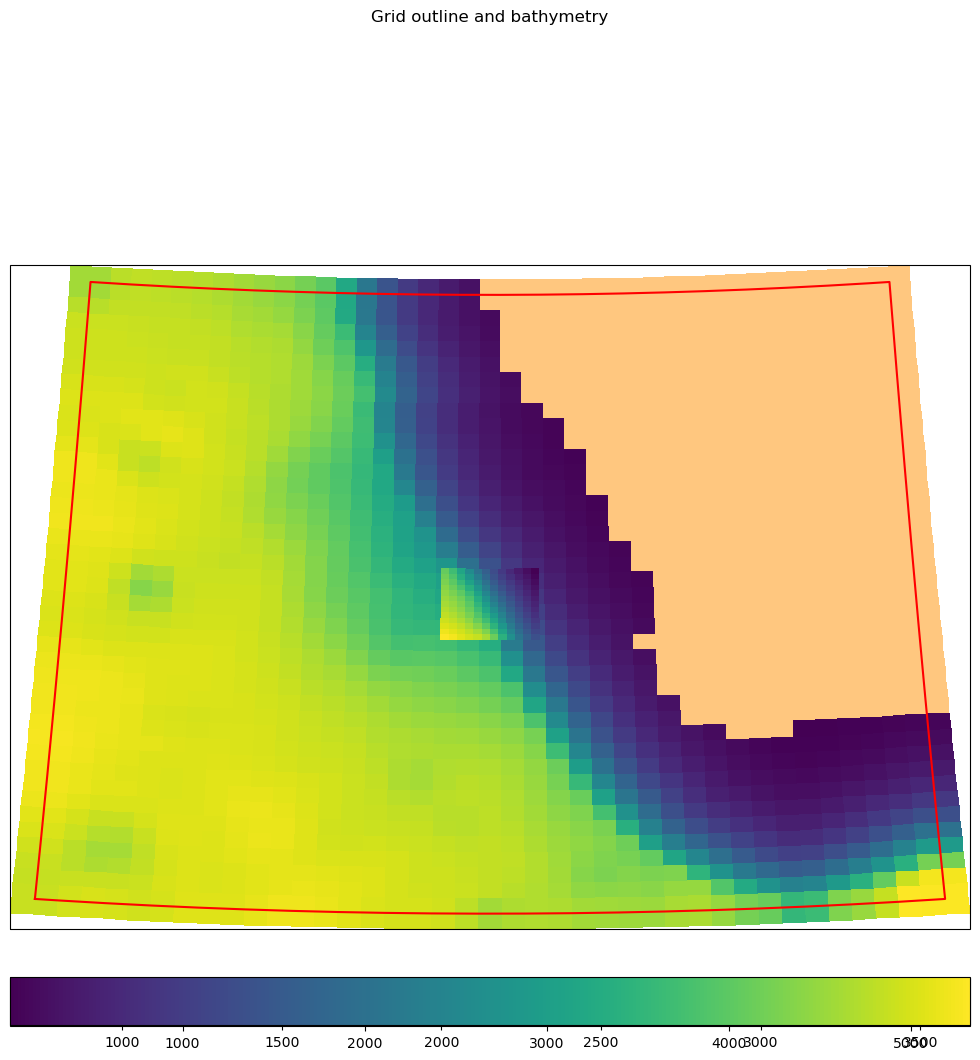

In [26]:
figure2

### Save grid as necdf

This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook. Then it saves it in the ouput repertory.

In [27]:
CROCO.create_grid_nc(None,output_file,inputs,outputs)

Writting ../../CROCO_FILES/croco_chd_grd.nc done


In [28]:
CROCO.create_grid_nc(None,'../../CROCO_FILES/croco_chd_orig_grd.nc',inputs,outputs_original)

Writting ../../CROCO_FILES/croco_chd_orig_grd.nc done
